In [162]:
from functions.data_by_country import data_by_country
from utils.data_loader import load_data_parquet
import matplotlib.pyplot as plt
import pandas as pd
import pycountry
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import numpy as np
from sklearn.linear_model import LinearRegression

In [133]:
df = load_data_parquet()
df = data_by_country(df)
df = df.dropna()


c:\Users\gaute\OneDrive\Malmø\1st semester\AI\World_Temperature_Analysis\functions\data_by_country.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = data[["Country", "AverageTemperature", "dt"]


In [134]:
#df = df.set_index("dt")

In [135]:
df = df[df["Country"]=="Sweden"]

In [136]:
df

,Country,dt,AverageTemperature
440504,Sweden,1743-11-01,3.7652
440509,Sweden,1744-04-01,3.3624
440510,Sweden,1744-05-01,8.8490
440511,Sweden,1744-06-01,13.0116
440512,Sweden,1744-07-01,15.6892
...,...,...,...
443737,Sweden,2013-04-01,3.3374
443738,Sweden,2013-05-01,11.9138
443739,Sweden,2013-06-01,14.8738
443740,Sweden,2013-07-01,17.3276


In [137]:
# Choosing some data to make the arima model with
df = df.loc[(df.dt >= "2000-01-01") & (df.dt <= "2013-08-01")]

In [138]:
df

,Country,dt,AverageTemperature
443578,Sweden,2000-01-01,-0.0738
443579,Sweden,2000-02-01,0.3756
443580,Sweden,2000-03-01,1.5902
443581,Sweden,2000-04-01,5.9578
443582,Sweden,2000-05-01,11.3468
...,...,...,...
443737,Sweden,2013-04-01,3.3374
443738,Sweden,2013-05-01,11.9138
443739,Sweden,2013-06-01,14.8738
443740,Sweden,2013-07-01,17.3276


First we look at the time series...

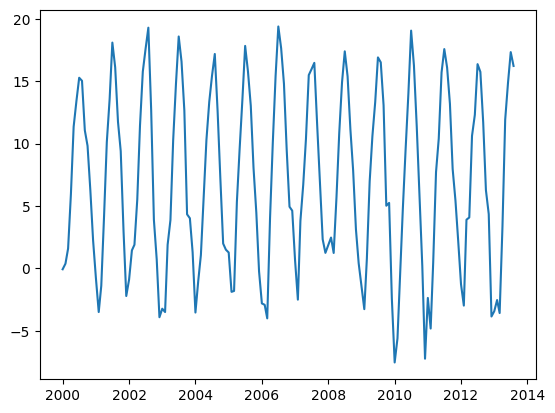

In [139]:
plt.plot(df.dt,df["AverageTemperature"])

Then we have to make the data stationary

Sources: 
https://github.com/jinit24/ARIMA-Model/blob/master/ARIMA.ipynb 

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [140]:
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series
# data can said to have stationarity
#
from statsmodels.tsa.stattools import adfuller
#
# Run the test
#
df_stationarityTest = adfuller(df['AverageTemperature'], autolag='AIC')
#
# Check the value of p-value
#
print("P-value: ", df_stationarityTest[1])

P-value:  0.0385944703203704


In [141]:
# df_testing = pd.DataFrame(np.log(df.AverageTemperature).diff().diff(12))
# df_testing.dropna()

In [142]:
result = adfuller(df['AverageTemperature'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -2.962042
p-value: 0.038594
Critical Values:
	1%: -3.474
	5%: -2.881
	10%: -2.577
Reject Ho - Time Series is Stationary


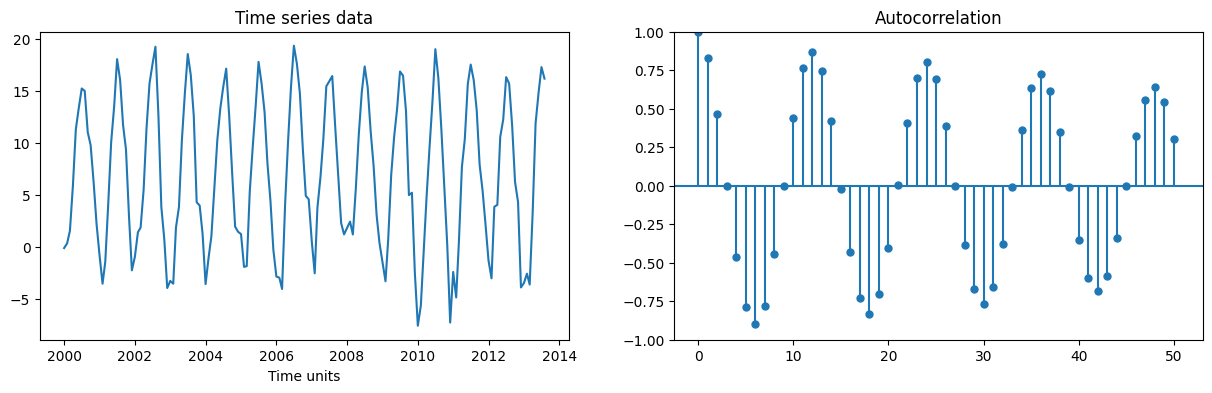

In [143]:

# plot the time series and the ACF
fig, axes = plt.subplots(1,2,figsize=(15,4))
axes[0].plot(df.dt,df["AverageTemperature"])
axes[0].set_title('Time series data')
axes[0].set(xlabel='Time units')
plot_acf(df.AverageTemperature,alpha=1,lags=50,ax=axes[1])
plt.show()

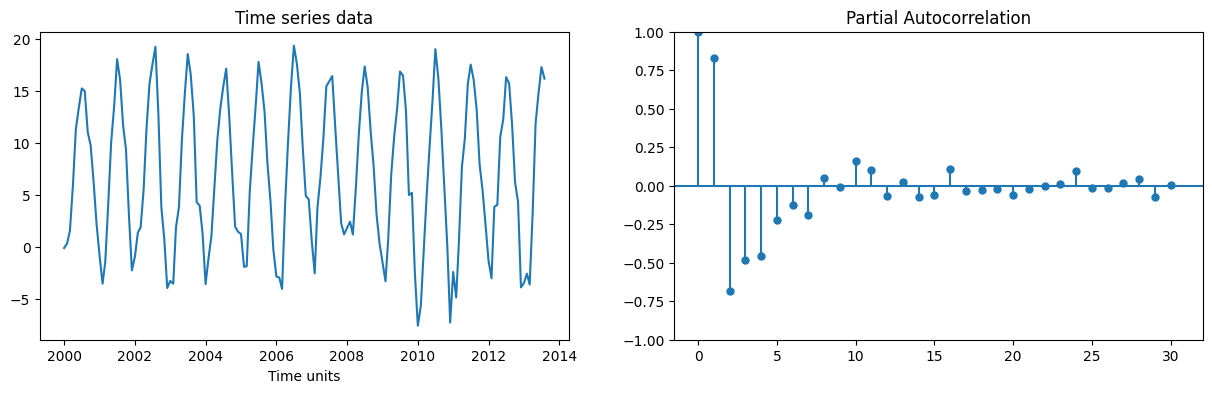

In [144]:
# plot the time series and the ACF
fig, axes = plt.subplots(1,2,figsize=(15,4))
axes[0].plot(df.dt,df["AverageTemperature"])
axes[0].set_title('Time series data')
axes[0].set(xlabel='Time units')
plot_pacf(df.AverageTemperature,alpha=1,lags=30,ax=axes[1])
plt.show()

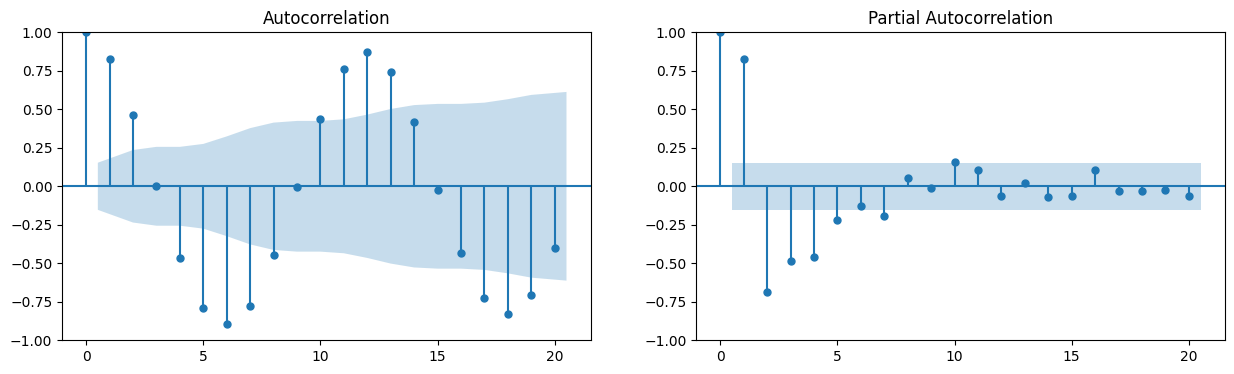

In [145]:
fig, axs = plt.subplots(1,2,figsize=(15,4))
plot_acf(df["AverageTemperature"], lags=20, ax=axs[0])
plot_pacf(df["AverageTemperature"], lags=20, ax=axs[1])
plt.show()

Based on acf, we have 2 lags, and with pacf 5 lags. Therefore, we should test the arima model from 2-5 lags

In [146]:
df["temperatures_shifted"]= df["AverageTemperature"].shift()

C:\Users\gaute\AppData\Local\Temp\ipykernel_35480\2978830036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temperatures_shifted"]= df["AverageTemperature"].shift()


In [147]:
df.head()

,Country,dt,AverageTemperature,temperatures_shifted
443578,Sweden,2000-01-01,-0.0738,NaN
443579,Sweden,2000-02-01,0.3756,-0.0738
443580,Sweden,2000-03-01,1.5902,0.3756
443581,Sweden,2000-04-01,5.9578,1.5902
443582,Sweden,2000-05-01,11.3468,5.9578


In [148]:
df.dropna(inplace=True)

C:\Users\gaute\AppData\Local\Temp\ipykernel_35480\1379821321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [149]:
df.head()

,Country,dt,AverageTemperature,temperatures_shifted
443579,Sweden,2000-02-01,0.3756,-0.0738
443580,Sweden,2000-03-01,1.5902,0.3756
443581,Sweden,2000-04-01,5.9578,1.5902
443582,Sweden,2000-05-01,11.3468,5.9578
443583,Sweden,2000-06-01,13.4314,11.3468


In [150]:
# Dropping values we dont need
df.drop(["dt","Country"],axis = 1, inplace = True)

C:\Users\gaute\AppData\Local\Temp\ipykernel_35480\572376372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["dt","Country"],axis = 1, inplace = True)


In [151]:
df.head()

,AverageTemperature,temperatures_shifted
443579,0.3756,-0.0738
443580,1.5902,0.3756
443581,5.9578,1.5902
443582,11.3468,5.9578
443583,13.4314,11.3468


In [152]:
y = df.AverageTemperature.values
X = df.temperatures_shifted.values

In [155]:
train_size = int(len(X)*0.8)

In [156]:
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [157]:
X_train

array([-0.0738,  0.3756,  1.5902,  5.9578, 11.3468, 13.4314, 15.2748,
       15.0294, 11.0626,  9.8188,  6.2276,  2.2456, -0.7798, -3.5006,
       -1.397 ,  4.2456, 10.1234, 13.568 , 18.0912, 16.114 , 11.7362,
        9.3938,  2.973 , -2.2162, -0.8994,  1.441 ,  1.8924,  5.5102,
       11.4338, 15.764 , 17.564 , 19.2868, 12.6848,  3.8874,  0.7168,
       -3.9176, -3.2334, -3.5018,  1.8886,  3.8724, 10.259 , 14.8158,
       18.5814, 16.5728, 12.6484,  4.3308,  4.0128,  1.2968, -3.5406,
       -0.9982,  1.0674,  5.7132, 10.2926, 13.3404, 15.41  , 17.1792,
       12.5906,  7.2226,  1.9854,  1.496 ,  1.2696, -1.8838, -1.811 ,
        5.3252,  9.5314, 13.5612, 17.8262, 15.7768, 13.0204,  8.0622,
        4.453 , -0.2484, -2.8104, -2.9232, -4.0078,  4.0626, 10.0394,
       15.4224, 19.383 , 17.643 , 14.7862,  9.5148,  4.9384,  4.6202,
        0.658 , -2.5078,  3.8066,  6.7048, 10.3818, 15.4888, 15.9564,
       16.468 , 11.5426,  6.9754,  2.3254,  1.2412,  1.8518,  2.4682,
        1.2334,  5.7

In [158]:
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
     

In [159]:
X_train

array([[-0.0738],
       [ 0.3756],
       [ 1.5902],
       [ 5.9578],
       [11.3468],
       [13.4314],
       [15.2748],
       [15.0294],
       [11.0626],
       [ 9.8188],
       [ 6.2276],
       [ 2.2456],
       [-0.7798],
       [-3.5006],
       [-1.397 ],
       [ 4.2456],
       [10.1234],
       [13.568 ],
       [18.0912],
       [16.114 ],
       [11.7362],
       [ 9.3938],
       [ 2.973 ],
       [-2.2162],
       [-0.8994],
       [ 1.441 ],
       [ 1.8924],
       [ 5.5102],
       [11.4338],
       [15.764 ],
       [17.564 ],
       [19.2868],
       [12.6848],
       [ 3.8874],
       [ 0.7168],
       [-3.9176],
       [-3.2334],
       [-3.5018],
       [ 1.8886],
       [ 3.8724],
       [10.259 ],
       [14.8158],
       [18.5814],
       [16.5728],
       [12.6484],
       [ 4.3308],
       [ 4.0128],
       [ 1.2968],
       [-3.5406],
       [-0.9982],
       [ 1.0674],
       [ 5.7132],
       [10.2926],
       [13.3404],
       [15.41  ],
       [17

Now we need to do linear regression on the training data

In [160]:
def simple_linear_regression(X, y):
    """
    Implement simple linear regression without specifying learning rates or epochs.

    Parameters:
    - X (numpy array): Feature matrix (independent variable).
    - y (numpy array): Target vector (dependent variable).

    Returns:
    - w (float): Learned weight (coefficient).
    - b (float): Learned bias (intercept).
    """
    # Calculate the coefficients using the closed-form solution
    X_mean = np.mean(X)
    y_mean = np.mean(y)
    num_samples = len(X)

    numerator = sum((X[i] - X_mean) * (y[i] - y_mean) for i in range(num_samples))
    denominator = sum((X[i] - X_mean) ** 2 for i in range(num_samples))

    w = numerator / denominator
    b = y_mean - w * X_mean

    return w, b

In [171]:
result = simple_linear_regression(X_train,y_train)
result

(array([0.83222999]), array([1.19504909]))

How does it compare to the sklearn library?

In [164]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [165]:
print(lr.coef_)
print(lr.intercept_)

[0.83222999]
1.1950490940103746


In [166]:
def predict_simple_linear_regression(X, w, b):
    """
    Make predictions using the learned coefficients.

    Parameters:
    - X (numpy array): Feature matrix of new data points.
    - w (float): Learned weight (coefficient).
    - b (float): Learned bias (intercept).

    Returns:
    - predictions (numpy array): Predicted values for the new data points.
    """
    predictions = w * X + b
    return predictions

In [172]:
predict_simple_linear_regression(X_train,result[0],result[1])

array([[ 1.13363052e+00],
       [ 1.50763468e+00],
       [ 2.51846122e+00],
       [ 6.15330891e+00],
       [ 1.06381963e+01],
       [ 1.23730629e+01],
       [ 1.39071957e+01],
       [ 1.37029665e+01],
       [ 1.04016765e+01],
       [ 9.36654889e+00],
       [ 6.37784456e+00],
       [ 3.06390475e+00],
       [ 5.46076150e-01],
       [-1.71825520e+00],
       [ 3.24238020e-02],
       [ 4.72836473e+00],
       [ 9.62004615e+00],
       [ 1.24867456e+01],
       [ 1.62510882e+01],
       [ 1.46056031e+01],
       [ 1.09622667e+01],
       [ 9.01285115e+00],
       [ 3.66926885e+00],
       [-6.49339003e-01],
       [ 4.46541444e-01],
       [ 2.39429251e+00],
       [ 2.76996112e+00],
       [ 5.78080277e+00],
       [ 1.07106003e+01],
       [ 1.43143226e+01],
       [ 1.58123366e+01],
       [ 1.72461024e+01],
       [ 1.17517200e+01],
       [ 4.43025995e+00],
       [ 1.79159155e+00],
       [-2.06529510e+00],
       [-1.49588335e+00],
       [-1.71925387e+00],
       [ 2.7

In [173]:
lr.predict(X_train)

array([ 1.13363052e+00,  1.50763468e+00,  2.51846122e+00,  6.15330891e+00,
        1.06381963e+01,  1.23730629e+01,  1.39071957e+01,  1.37029665e+01,
        1.04016765e+01,  9.36654889e+00,  6.37784456e+00,  3.06390475e+00,
        5.46076150e-01, -1.71825520e+00,  3.24238020e-02,  4.72836473e+00,
        9.62004615e+00,  1.24867456e+01,  1.62510882e+01,  1.46056031e+01,
        1.09622667e+01,  9.01285115e+00,  3.66926885e+00, -6.49339003e-01,
        4.46541444e-01,  2.39429251e+00,  2.76996112e+00,  5.78080277e+00,
        1.07106003e+01,  1.43143226e+01,  1.58123366e+01,  1.72461024e+01,
        1.17517200e+01,  4.43025995e+00,  1.79159155e+00, -2.06529510e+00,
       -1.49588335e+00, -1.71925387e+00,  2.76679865e+00,  4.41777650e+00,
        9.73289653e+00,  1.35252021e+01,  1.66590474e+01,  1.49874302e+01,
        1.17214269e+01,  4.79927072e+00,  4.53462159e+00,  2.27428494e+00,
       -1.75154440e+00,  3.64317121e-01,  2.08337138e+00,  5.94974546e+00,
        9.76085946e+00,  